In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

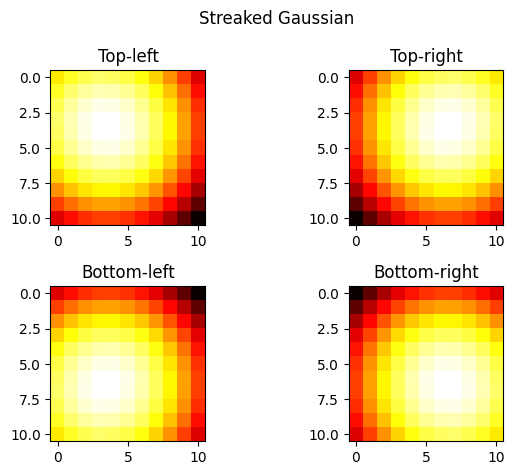

In [3]:
def generate_streaked_gaussian(
    n, direction, std_dev_center=10.0, std_dev_corner=15.0, weight_corner=0.5
):
    x = np.linspace(0, n - 1, n)
    y = np.linspace(0, n - 1, n)
    xv, yv = np.meshgrid(x, y)

    center_x, center_y = (n - 1) / 2, (n - 1) / 2
    gaussian_center = np.exp(
        -(((xv - center_x) ** 2 + (yv - center_y) ** 2) / (2 * std_dev_center**2))
    )

    if direction == 0:  # Top-left
        corner_x, corner_y = 0, 0
    elif direction == 1:  # Top-right
        corner_x, corner_y = n - 1, 0
    elif direction == 2:  # Bottom-left
        corner_x, corner_y = 0, n - 1
    elif direction == 3:  # Bottom-right
        corner_x, corner_y = n - 1, n - 1
    else:
        raise ValueError("Direction must be one of 0, 1, 2, 3")

    gaussian_corner = np.exp(
        -(((xv - corner_x) ** 2 + (yv - corner_y) ** 2) / (2 * std_dev_corner**2))
    )

    streaked_gaussian = (
        1 - weight_corner
    ) * gaussian_center + weight_corner * gaussian_corner

    return streaked_gaussian


n = 11
tl = generate_streaked_gaussian(n, 0)
tr = generate_streaked_gaussian(n, 1)
bl = generate_streaked_gaussian(n, 2)
br = generate_streaked_gaussian(n, 3)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(tl, cmap="hot")
axs[0, 0].set_title("Top-left")
axs[0, 1].imshow(tr, cmap="hot")
axs[0, 1].set_title("Top-right")
axs[1, 0].imshow(bl, cmap="hot")
axs[1, 0].set_title("Bottom-left")
axs[1, 1].imshow(br, cmap="hot")
axs[1, 1].set_title("Bottom-right")
fig.suptitle("Streaked Gaussian")
plt.tight_layout()
plt.show()

In [4]:
from glob import glob

import pandas as pd
import cv2
from sklearn.model_selection import GroupKFold


class DataManager(object):
    """Class to manage data loading, processing, and cross-validation"""

    def __init__(self, config):
        data_dir = config["data_dir"]
        self.num_folds = config["num_folds"]
        self.config = config
        self.list_of_paths_to_hr_images = sorted(list(glob(data_dir + "/HR/*")))
        self.list_of_paths_to_lr_images = [
            path.replace("/HR/", "/LR/").replace(".png", "x4m.png")
            for path in self.list_of_paths_to_hr_images
        ]
        self.list_of_hr_images = [
            cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            for path in self.list_of_paths_to_hr_images
        ]
        self.list_of_lr_images = [
            cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            for path in self.list_of_paths_to_lr_images
        ]

        self.hr_image_shape = self.list_of_hr_images[0].size
        self.lr_image_shape = self.list_of_lr_images[0].size

        self.df = pd.DataFrame(
            {
                "hr_path": self.list_of_paths_to_hr_images,
                "lr_path": self.list_of_paths_to_lr_images,
                "hr_image": self.list_of_hr_images,
                "lr_image": self.list_of_lr_images,
            }
        )
        self._make_folds()

    def create_patches(self, patch_fraction, stride_fraction):
        """Create image patches"""
        hr_patch_size = int(self.hr_image_shape[0] * patch_fraction)
        lr_patch_size = int(self.lr_image_shape[0] * patch_fraction)
        hr_stride = int(hr_patch_size * stride_fraction)
        lr_stride = int(lr_patch_size * stride_fraction)

        assert (
            hr_patch_size / lr_patch_size == 4
        ), "HR patch size should be 4 times LR patch size"
        assert hr_stride / lr_stride == 4, "HR stride should be 4 times LR stride"

        self.df["hr_patches"] = self.df["hr_image"].apply(
            lambda x: self._create_image_patches(x, patch_size=128, stride=64)
        )
        self.df["lr_patches"] = self.df["lr_image"].apply(
            lambda x: self._create_image_patches(x, patch_size=32, stride=16)
        )
        self.df.loc[:, "patches"] = self.df.apply(
            lambda x: list(zip(x["lr_patches"], x["hr_patches"])), axis=1
        )
        self.df = self.df.explode("patches")
        self.df["lr_patch"] = self.df["patches"].apply(lambda x: x[0])
        self.df["hr_patch"] = self.df["patches"].apply(lambda x: x[1])

        self.df.drop(columns=["lr_patches", "hr_patches", "patches"], inplace=True)

    @staticmethod
    def _create_image_patches(image, patch_size, stride):
        """Create image patches"""
        patches = []
        for i in range(0, image.size[0] - patch_size + 1, stride):
            for j in range(0, image.size[1] - patch_size + 1, stride):
                patch = image.crop((i, j, i + patch_size, j + patch_size))
                patches.append(patch)
        return patches

    def _make_folds(self):
        """Create folds for cross-validation"""
        # NOTE: group k fold because we want all the patches of an image to be in the same fold
        kfold = GroupKFold(n_splits=self.num_folds)
        self.df["fold"] = -1
        for fold, (_, val_idx) in enumerate(
            kfold.split(self.df, groups=self.df["hr_path"])
        ):
            self.df.loc[val_idx, "fold"] = fold

    def get_fold(self, fold):
        """Get data for a specific fold"""
        return self.df[self.df["fold"] != fold], self.df[self.df["fold"] == fold]

In [5]:
import numpy as np
from skimage.metrics import mean_squared_error, structural_similarity
from sklearn.metrics import mean_absolute_error


class Metrics:
    """Class to manage metrics."""

    @staticmethod
    def mse(true_hr_image, predicted_hr_image):
        return mean_squared_error(true_hr_image, predicted_hr_image)

    @staticmethod
    def ssim(true_hr_image, predicted_hr_image):
        return structural_similarity(
            true_hr_image, predicted_hr_image, multichannel=True, channel_axis=2
        )

    @staticmethod
    def mae(true_hr_image, predicted_hr_image):
        true_hr_image = true_hr_image.reshape(-1)
        predicted_hr_image = predicted_hr_image.reshape(-1)
        return mean_absolute_error(true_hr_image, predicted_hr_image)

    @staticmethod
    def generate_metric_report(list_of_hr_images, list_of_predictions):
        """Generate metric report."""

        # typecast according to the metrics input is list of PIL images
        list_of_hr_images = [np.array(hr_image) for hr_image in list_of_hr_images]
        list_of_predictions = [
            np.array(prediction) for prediction in list_of_predictions
        ]

        mae = [
            Metrics.mae(hr_image, prediction)
            for hr_image, prediction in zip(list_of_hr_images, list_of_predictions)
        ]
        ssim = [
            Metrics.ssim(hr_image, prediction)
            for hr_image, prediction in zip(list_of_hr_images, list_of_predictions)
        ]
        return {"ssim": list(map(float, ssim)), "mae": list(map(float, mae))}

In [6]:
config = {
    "data": {
        "data_dir": "data/SuperResolution",
        "num_folds": 10,
    },
    "model": {
        "model_type": "InterpolationModel",
    },
    "path_to_artifacts_dir": "artifacts",
}

data_config = config["data"]
model_config = config["model"]
path_to_artifacts_dir = config["path_to_artifacts_dir"]

# data

In [7]:
data_manager = DataManager(
    config=data_config,
)

df_train, df_valid = data_manager.get_fold(0)
train_lr_images = df_train["lr_image"].values[:2]  # DEBUG: increase this number
train_hr_images = df_train["hr_image"].values[:2]
val_lr_images = df_valid["lr_image"].values
val_hr_images = df_valid["hr_image"].values

df_train.shape, df_valid.shape, len(train_hr_images), len(val_hr_images), len(
    train_lr_images
), len(val_lr_images)

((45, 5), (5, 5), 2, 5, 2, 5)

100%|██████████| 2/2 [00:00<00:00, 28.82it/s]


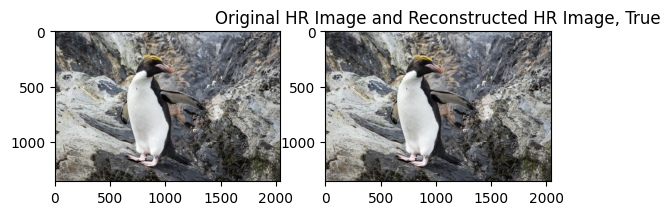

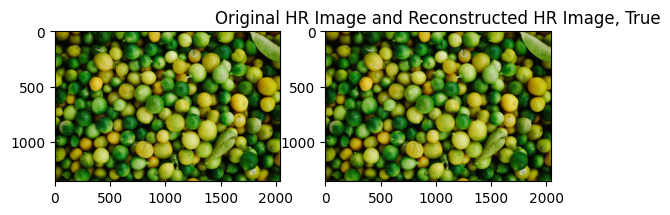

In [8]:
class Patchify:
    def __init__(self, lr_images, hr_images, lr_patch_size):
        self.lr_images = [image / 255.0 for image in lr_images]
        self.hr_images = [image / 255.0 for image in hr_images]
        self.lr_patch_size = lr_patch_size

        # NOTE: dirty padding adds some noise
        dirty_padded_hr_images = []
        for lr_image, hr_image in zip(lr_images, hr_images):
            hr_image = Patchify.dirty_padding(lr_image, hr_image)
            dirty_padded_hr_images.append(hr_image)
        self.hr_images = dirty_padded_hr_images

        # hr patch size is the upscaling factor, automatically inferred from the size of the images
        self.hr_patch_size = hr_images[0].shape[0] // lr_images[0].shape[0]

        self.idx2lr_patches = {}
        self.idx2hr_patches = {}

    @staticmethod
    def dirty_padding(lr_image, hr_image):
        # pad the hr image until its shape is multiple of the lr image dimensions
        lr_image_shape = lr_image.shape
        hr_image_shape = hr_image.shape

        # print("lr image shape", lr_image_shape)
        # print("hr image shape", hr_image_shape)

        padding_x = hr_image_shape[0] % lr_image_shape[0]
        padding_y = hr_image_shape[1] % lr_image_shape[1]

        padding_x = (lr_image_shape[0] - padding_x) if padding_x != 0 else 0
        padding_y = (lr_image_shape[1] - padding_y) if padding_y != 0 else 0
        # print("padding x", padding_x)
        # print("padding y", padding_y)

        if padding_x == 0 and padding_y == 0:
            return hr_image
        hr_image = np.pad(hr_image, ((0, padding_x), (0, padding_y)), mode="constant")
        # print("new hr image shape", hr_image.shape)
        return hr_image

    @staticmethod
    def _pad_image(patch, padding_size, mode):
        # pad the 3 channel image
        return np.pad(
            patch,
            ((padding_size, padding_size), (padding_size, padding_size), (0, 0)),
            mode=mode,
        )

    @staticmethod
    def _extract_lr_patches(image, patch_size, padding_strategy="constant"):
        patches = []
        padding_size = int(patch_size // 2)
        padded_image = Patchify._pad_image(
            image, padding_size=padding_size, mode=padding_strategy
        )
        # get patches such that each pixel is a center of a patch
        for i in range(padding_size, padded_image.shape[0] - padding_size):
            for j in range(padding_size, padded_image.shape[1] - padding_size):
                patch = padded_image[
                    i - padding_size : i + padding_size + 1,
                    j - padding_size : j + padding_size + 1,
                ]
                patches.append(patch)
                # print("extracted patch shape", patch.shape)
        return patches

    def get_lr_patches(self):
        for idx, lr_image in tqdm(enumerate(self.lr_images), total=len(self.lr_images)):
            lr_patches = Patchify._extract_lr_patches(lr_image, self.lr_patch_size)
            self.idx2lr_patches[idx] = lr_patches

        Patchify._check_lr_patching(self.idx2lr_patches, self.lr_images)
        return self.idx2lr_patches

    @staticmethod
    def _extract_hr_patches(image, patch_size):
        patches = []
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i : i + patch_size, j : j + patch_size]
                patches.append(patch)

        return patches

    def get_hr_patches(self):
        # the hr images will be of size (lr_image_width * hr_patch_size, lr_image_height * hr_patch_size)
        # make as manu patches as the number of pixels in the lr image each of size (hr_patch_size, hr_patch_size)
        for idx, hr_image in tqdm(enumerate(self.hr_images), total=len(self.hr_images)):
            # print( "num pixels in lr image", self.lr_images[idx].shape[0]*self.lr_images[idx].shape[1])
            # print("num pixels in hr image", hr_image.shape[0]*hr_image.shape[1])
            hr_patches = Patchify._extract_hr_patches(hr_image, self.hr_patch_size)
            # print("num hr patches", len(hr_patches))
            self.idx2hr_patches[idx] = hr_patches

        Patchify._check_hr_patching(
            self.idx2hr_patches, self.hr_images, self.lr_images, self.hr_patch_size
        )
        return self.idx2hr_patches

    @staticmethod
    def _check_hr_patching(idx2hr_patches, hr_images, lr_images, hr_patch_size):
        for idx, hr_image in enumerate(hr_images):
            # print("num hr patches should be equal to num pixels in lr image", len(idx2hr_patches[idx]), lr_images[idx].shape[0]*lr_images[idx].shape[1])
            assert (
                len(idx2hr_patches[idx])
                == lr_images[idx].shape[0] * lr_images[idx].shape[1]
            ), f"{len(idx2hr_patches[idx])} != {lr_images[idx].shape[0]*lr_images[idx].shape[1]}"
            # print("patch size should be equal to upscaling factor", idx2hr_patches[idx][0].shape, (hr_patch_size, hr_patch_size))
            assert idx2hr_patches[idx][0].shape == (
                hr_patch_size,
                hr_patch_size,
                3,
            ), f"{idx2hr_patches[idx][0].shape} != {(hr_patch_size, hr_patch_size)}"

    @staticmethod
    def _check_lr_patching(idx2lr_patches, lr_images):
        for idx, lr_image in enumerate(lr_images):
            assert (
                len(idx2lr_patches[idx]) == lr_image.shape[0] * lr_image.shape[1]
            ), f"{len(idx2lr_patches[idx])} != {lr_image.shape[0]*lr_image.shape[1]}"

    @staticmethod
    def get_image_from_lr_patches(lr_patches, lr_image_shape, patch_size):
        raise NotImplementedError(
            "this function is not needed, you should only use get_image_from_hr_patches"
        )

    @staticmethod
    def get_image_from_hr_patches(hr_patches, lr_image_shape):
        image = []
        for i in range(lr_image_shape[0]):
            image_row = []
            for j in range(lr_image_shape[1]):
                image_row.append(hr_patches[i * lr_image_shape[1] + j])
            image_row = np.concatenate(image_row, axis=1)
            image.append(image_row)
        image = np.concatenate(image, axis=0)
        return image


# ########################## testing the patchify class ############################
some_train_lr_images, some_train_hr_images = train_lr_images[:5], train_hr_images[:5]
patchify = Patchify(
    lr_images=some_train_lr_images, hr_images=some_train_hr_images, lr_patch_size=5
)
idx2lr_patches = patchify.get_lr_patches()
idx2hr_patches = patchify.get_hr_patches()

hr_images_reconstructed = []
for idx, hr_patches in idx2hr_patches.items():
    hr_image = Patchify.get_image_from_hr_patches(
        hr_patches, train_lr_images[idx].shape
    )
    hr_images_reconstructed.append(hr_image)

for hr_image, hr_image_reconstructed in zip(train_hr_images, hr_images_reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(hr_image)
    plt.subplot(1, 2, 2)
    plt.imshow(hr_image_reconstructed)
    plt.title(
        f"Original HR Image and Reconstructed HR Image, {np.allclose(hr_image, hr_image_reconstructed)}"
    )
    plt.show()

In [9]:
list_of_patches = []
for patch in idx2lr_patches[0]:
    list_of_patches.append(patch)
np.zeros(len(list_of_patches)).shape

(172890,)

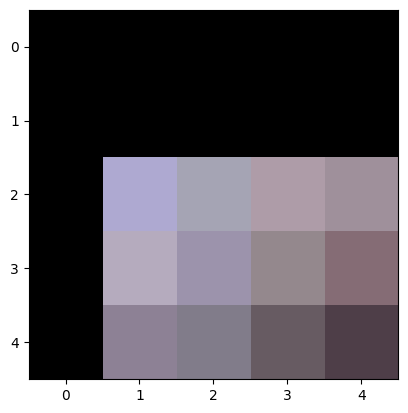

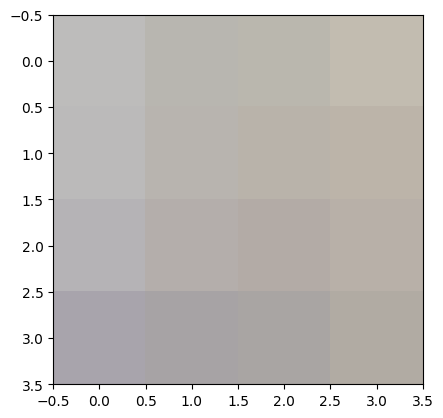

In [12]:
plt.imshow(idx2lr_patches[0][1])
plt.show()
plt.imshow(idx2hr_patches[0][1])
plt.show()

In [10]:
class SuperResolution(object):
    def __init__(
        self,
        inference_mode=True,
        train_hr_images=None,
        train_lr_images=None,
        val_hr_images=None,
        val_lr_images=None,
        super_resolution_ratio=None,
        train_patch_size=11,
        path_to_models_dir=None,
    ):
        self.super_resolution_ratio = super_resolution_ratio
        self.train_patch_size = train_patch_size
        self.num_models = super_resolution_ratio * super_resolution_ratio * 3

        if not path_to_models_dir:
            self.path_to_models_dir = "models"
            os.makedirs(self.path_to_models_dir, exist_ok=True)
        else:
            self.path_to_models_dir = path_to_models_dir

        self.models = [LinearRegression() for _ in range(self.num_models)]

        if inference_mode:
            pass

        else:
            self.train_patchify = Patchify(
                train_lr_images, train_hr_images, train_patch_size
            )
            self.train_idx2lr_patches = self.train_patchify.get_lr_patches()
            self.train_idx2hr_patches = self.train_patchify.get_hr_patches()

            self.val_patchify = Patchify(val_lr_images, val_hr_images, train_patch_size)
            self.val_idx2lr_patches = self.val_patchify.get_lr_patches()
            self.val_idx2hr_patches = self.val_patchify.get_hr_patches()

            self.model_idx2y_train = {}
            self.model_idx2y_val = {}

            for model_idx in range(self.num_models):
                self.model_idx2y_train[model_idx] = []
                self.model_idx2y_val[model_idx] = []
                for hr_patches in tqdm(
                    self.train_idx2hr_patches.values(),
                    total=len(self.train_idx2hr_patches),
                    desc=f"train data for model {model_idx}",
                ):
                    for hr_patch in hr_patches:
                        self.model_idx2y_train[model_idx].append(
                            hr_patch.flatten()[model_idx]
                        )
                self.model_idx2y_train[model_idx] = np.array(
                    self.model_idx2y_train[model_idx]
                )

                for hr_patches in tqdm(
                    self.val_idx2hr_patches.values(),
                    total=len(self.val_idx2hr_patches),
                    desc=f"val data for model {model_idx}",
                ):
                    for hr_patch in hr_patches:
                        self.model_idx2y_val[model_idx].append(
                            hr_patch.flatten()[model_idx]
                        )
                self.model_idx2y_val[model_idx] = np.array(
                    self.model_idx2y_val[model_idx]
                )

            for model_idx, y_train in self.model_idx2y_train.items():
                print(f"model {model_idx} y_train shape", y_train.shape)

            # since the input is the same for all the pixel predictors we can use the same input for all the models
            self.X_train = []
            for lr_patches in tqdm(
                self.train_idx2lr_patches.values(),
                total=len(self.train_idx2lr_patches),
                desc="train features",
            ):
                for lr_patch in lr_patches:
                    self.X_train.append(lr_patch.ravel())
            self.X_val = []
            for lr_patch in tqdm(
                self.val_idx2lr_patches.values(),
                total=len(self.val_idx2lr_patches),
                desc="val features",
            ):
                for lr_patch in lr_patches:
                    self.X_val.append(lr_patch.ravel())
            self.X_train = np.array(self.X_train)
            self.X_val = np.array(self.X_val)

            # scale the data
            self.X_train = self.X_train / 255.0
            self.X_val = self.X_val / 255.0

            print("train model data")
            for model_idx in range(self.num_models):
                for X, y in zip(self.X_train, self.model_idx2y_train[model_idx]):
                    break

            print("val model data")
            for model_idx in range(self.num_models):
                for X, y in zip(self.X_val, self.model_idx2y_val[model_idx]):
                    break

    def dump_models(self):
        for model_idx, model in enumerate(self.models):
            joblib.dump(model, f"{self.path_to_models_dir}/model_{model_idx}.pkl")

    def load_models(self):
        for model_idx in range(self.num_models):
            self.models[model_idx] = joblib.load(
                f"{self.path_to_models_dir}/model_{model_idx}.pkl"
            )

    def train(self):
        for model_idx in tqdm(
            range(self.num_models), total=self.num_models, desc="training models"
        ):
            self.models[model_idx].fit(self.X_train, self.model_idx2y_train[model_idx])

    def predict(self):
        y_preds = []
        for model_idx in range(self.num_models):
            y_pred = self.models[model_idx].predict(self.X_val)
            y_preds.append(y_pred)
        return y_preds

    def infer_image(self, image):
        lr_patches = Patchify._extract_lr_patches(image, self.train_patch_size)
        X = []
        for lr_patch in lr_patches:
            X.append(lr_patch.ravel())
        y_preds = []
        for model_idx in range(self.num_models):
            y_pred = self.models[model_idx].predict(X)
            y_preds.append(y_pred)
        hr_patches = []
        for i in range(len(y_preds[0])):
            hr_patch = []
            for model_idx in range(self.num_models):
                hr_patch.append(y_preds[model_idx][i])
            hr_patch = np.array(hr_patch)
            hr_patches.append(hr_patch)
        hr_image = Patchify.get_image_from_hr_patches(hr_patches, image.shape)
        return hr_image

    def evaluate(self, list_of_images):
        metrics = Metrics()
        list_of_predicted_images = []
        for image in list_of_images:
            hr_image = self.infer_image(image)
            list_of_predicted_images.append(hr_image)
        metric_report = metrics.generate_metric_report(hr_image, image)
        print(metric_report)


sisr = SuperResolution(
    inference_mode=False,
    train_hr_images=train_hr_images,
    train_lr_images=train_lr_images,
    val_hr_images=val_hr_images,
    val_lr_images=val_lr_images,
    super_resolution_ratio=4,
    train_patch_size=5,
    path_to_models_dir="models",
)

val data for model 47: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


model 0 y_train shape (345780,)
model 1 y_train shape (345780,)
model 2 y_train shape (345780,)
model 3 y_train shape (345780,)
model 4 y_train shape (345780,)
model 5 y_train shape (345780,)
model 6 y_train shape (345780,)
model 7 y_train shape (345780,)
model 8 y_train shape (345780,)
model 9 y_train shape (345780,)
model 10 y_train shape (345780,)
model 11 y_train shape (345780,)
model 12 y_train shape (345780,)
model 13 y_train shape (345780,)
model 14 y_train shape (345780,)
model 15 y_train shape (345780,)
model 16 y_train shape (345780,)
model 17 y_train shape (345780,)
model 18 y_train shape (345780,)
model 19 y_train shape (345780,)
model 20 y_train shape (345780,)
model 21 y_train shape (345780,)
model 22 y_train shape (345780,)
model 23 y_train shape (345780,)
model 24 y_train shape (345780,)
model 25 y_train shape (345780,)
model 26 y_train shape (345780,)
model 27 y_train shape (345780,)
model 28 y_train shape (345780,)
model 29 y_train shape (345780,)
model 30 y_train sha

val features: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


train model data
val model data


In [11]:
sisr.train()
sisr.dump_models()

training models: 100%|██████████| 48/48 [00:30<00:00,  1.57it/s]


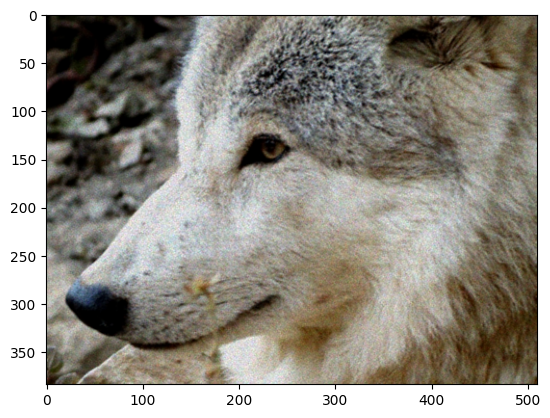

In [12]:
image = val_lr_images[0]
plt.imshow(image)

In [13]:
lr_patches = Patchify._extract_lr_patches(image, 5)
X = []
for lr_patch in lr_patches:
    X.append(lr_patch.ravel())
print(len(X), X[0].shape)
y_preds = []
for model_idx in range(sisr.num_models):
    y_pred = sisr.models[model_idx].predict(X)
    y_preds.append(y_pred)
print(len(y_preds), y_preds[0].shape)
predicted_image = np.zeros((image.shape[0] * 4, image.shape[1] * 4, 3))
list_of_pixels = []

for pixels_48 in zip(*y_preds):
    list_of_pixels.append(pixels_48)

for i in range(0, image.shape[0] * 4, 4):
    for j in range(0, image.shape[1] * 4, 4):
        for k in range(3):
            for l in range(4):
                for m in range(4):
                    predicted_image[i + l, j + m, k] = list_of_pixels[
                        (i // 4) * 25 + (j // 4)
                    ][k * 12 + l * 4 + m]

# turn all pixels that are white to 0
for i in range(predicted_image.shape[0]):
    for j in range(predicted_image.shape[1]):
        if np.all(predicted_image[i, j] == np.array([255, 255, 255])):
            predicted_image[i, j] = np.array([0, 0, 0])

195840 (75,)
48 (195840,)


In [14]:
# rescale the image
predicted_image = (predicted_image - np.min(predicted_image)) / (
    np.max(predicted_image) - np.min(predicted_image)
)
print(np.min(predicted_image), np.max(predicted_image))

0.0 1.0


In [15]:
predicted_image.shape, image.shape

((1536, 2040, 3), (384, 510, 3))

In [16]:
predicted_image.shape, image.shape

((1536, 2040, 3), (384, 510, 3))

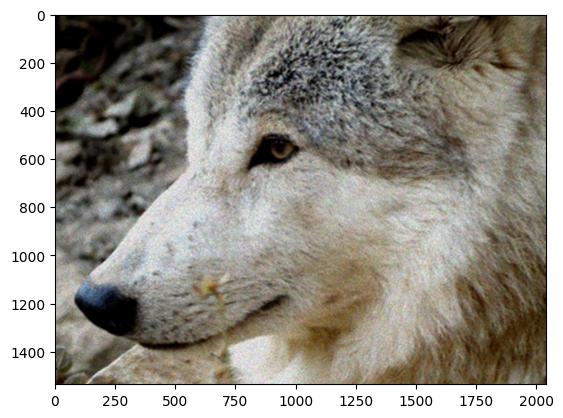

In [17]:
image = cv2.resize(
    image, (image.shape[1] * 4, image.shape[0] * 4), interpolation=cv2.INTER_CUBIC
)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09480881956543799..0.9820072765191483].


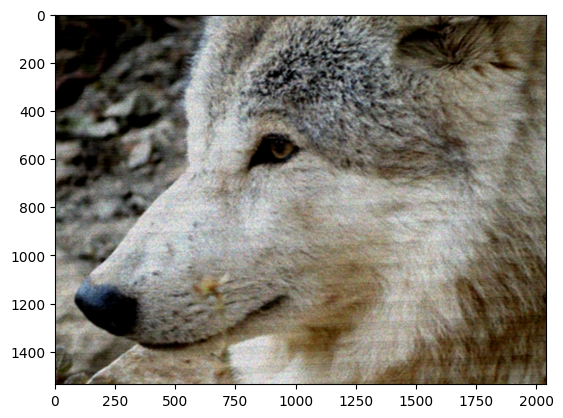

In [18]:
plt.imshow(image - predicted_image * 0.1)

In [19]:
image = []
lr_image_shape = (100, 100)
for i in range(lr_image_shape[0]):
    image_row = []
    for j in range(lr_image_shape[1]):
        image_row.append(hr_patches[i * lr_image_shape[1] + j])
    image_row = np.concatenate(image_row, axis=0)
    image.append(image_row)
image = np.concatenate(image, axis=0)

In [20]:
sisr.infer_image(val_lr_images[0][:100, :100])

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
len(sisr.X_train)

In [ ]:
patches = SuperResolution.extract_input_patches(
    image=padded_patch, patch_size=3, padding_strategy="constant"
)
for patch in patches:
    print(patch)
    plt.imshow(patch, cmap="gray")
    plt.show()